# This notebook is for creating and running the malaria model for the epi paper

Model adapted from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10733109/

### Load dependencies

In [17]:
import os
import json
import sympy
import torch
import requests
import numpy as np
import pandas as pd
from typing import Dict, List, Callable

# MIRA modeling dependencies
from mira.metamodel import *
from mira.metamodel.ops import stratify
from mira.examples.concepts import susceptible, exposed, infected, recovered
from mira.modeling import Model
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.sources.amr.petrinet import template_model_from_amr_json
from mira.metamodel.io import model_to_json_file, model_from_json_file

# PyCIEMSS dependencies
import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories
from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

## Build malaria (host-vector disease) model with MIRA

### Define units

In [3]:
person_units = lambda: Unit(expression=sympy.Symbol('person'))
mosquito_units = lambda: Unit(expression=sympy.Symbol('mosquito'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))

### Define model concepts

In [4]:
c = {
    # human population
    "Sh": Concept(name="Sh", units=person_units(), identifiers={"ido": "0000514"}),
    "Eh": Concept(name="Eh", units=person_units(), identifiers={"apollosv": "0000154"}),
    "Ih": Concept(name="Ih", units=person_units(), identifiers={"ido": "0000511"}),
    "Rh": Concept(name="Rh", units=person_units(), identifiers={"ido": "0000592"}),
    "Dh": Concept(name="Dh", units=person_units(), identifiers={"ncit": "C28554"}),

    # mosquito population (aquatic stage)
    "G": Concept(name="G", units=mosquito_units()), # eggs
    "L": Concept(name="L", units=mosquito_units()), # larvae
    "P": Concept(name="P", units=mosquito_units()), # pupae

    # mosquito population (adult stage)
    "Sm": Concept(name="Sm", units=mosquito_units()), # susceptible mosquito
    "Em": Concept(name="Em", units=mosquito_units()), # exposed mosquito
    "Im": Concept(name="Im", units=mosquito_units()), # infectious mosquito
}

for concept in c:
    c[concept].name = concept

### Define model parameters with uncertainty

In [5]:
I0_guess = 220
parameters = {
    # transition rates for human population
    'beta': Parameter(name='beta', value=sympy.Float(0.0044), units=per_day_units(),
                      distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.004,
                                                            'maximum': 0.005})),  # Transmission rate Sh -> Ih

    'I0': Parameter(name='I0', value=sympy.Float(I0_guess), units=per_day_units(),
                     distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.95*I0_guess,
                                                            'maximum': 1.05*I0_guess})),  # Initial value for Ih
    
    'rho': Parameter(name='rho', value=sympy.Float(0.1), units=per_day_units(),
                     distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.033,
                                                            'maximum': 0.14})),  # Rate of progressing Eh -> Ih
    
    'gamma': Parameter(name='gamma', value=sympy.Float(0.07), units=per_day_units()),  # Rate of progressing Ih -> Rh

    'mu': Parameter(name='mu', value=sympy.Float(0.0028), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.0025,
                                                            'maximum': 0.003})),  # Death rate Ih -> Dh
    
    'phi': Parameter(name='phi', value=sympy.Float(0.005), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.004,
                                                            'maximum': 0.006})),  # Rate of immunity loss Rh -> Sh
    
    # transition rates for mosquito population 
    'bm': Parameter(name='bm', value=sympy.Float(1.0), units=per_day_units()),  # Per capita oviposition rate of female mosquitoes

    'KG': Parameter(name='KG', value=sympy.Float(15_000), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 14_900,
                                                            'maximum': 15_500})),  # Carrying capacity for eggs

    'KL': Parameter(name='KL', value=sympy.Float(10_000), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 9500,
                                                            'maximum': 10_500})),  # Carrying capacity for larvae

    'KP': Parameter(name='KP', value=sympy.Float(7000), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 6500,
                                                            'maximum': 7500})),  # Carrying capacity for pupae

    'tau': Parameter(name='tau', value=sympy.Float(0.03), units=per_day_units()),  # Hatch rate G -> L

    'nu': Parameter(name='nu', value=sympy.Float(0.005), units=per_day_units()),  # Rate L -> P

    'eps': Parameter(name='eps', value=sympy.Float(0.002), units=per_day_units()),  # Rate P -> Sm

    'dG': Parameter(name='dG', value=sympy.Float(0.028), units=per_day_units()),  # Natural death rate of eggs
    'dL': Parameter(name='dL', value=sympy.Float(0.07), units=per_day_units()),  # Natural death rate of larvae
    'dP': Parameter(name='dP', value=sympy.Float(0.03), units=per_day_units()),  # Natural death rate of pupae
    
    'eta': Parameter(name='eta', value=sympy.Float(0.011), units=per_day_units()),  # Death rate of adult mosquitoes

    'kappai': Parameter(name='kappai', value=sympy.Float(0.0011), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.001,
                                                            'maximum': 0.0015})),  # Rate Sm -> Im after biting Ih

    'kappar': Parameter(name='kappar', value=sympy.Float(0.02), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.015,
                                                            'maximum': 0.03})),  # Rate Sm -> Im after biting Rh

    'chi': Parameter(name='chi', value=sympy.Float(0.06), units=per_day_units(),
                     distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.035,
                                                            'maximum': 0.1})),  # Rate of progressing Em -> Im

    'zeta': Parameter(name='zeta', value=sympy.Float(0.02), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.01,
                                                            'maximum': 0.03})),  # Rate at which G, L and P are eliminated by humans
}

### Define `SymPy` variables

In [6]:
Sh, Eh, Ih, Rh, Dh, G, L, P, Sm, Em, Im, beta, I0, rho, gamma, mu, phi, bm, KG, KL, KP, tau, nu, eps, dG, dL, dP, eta, kappai, kappar, chi, zeta = sympy.symbols(
    'Sh Eh Ih Rh Dh G L P Sm Em Im beta I0 rho gamma mu phi bm KG KL KP tau nu eps dG dL dP eta kappai kappar chi zeta')

### Set initial conditions

In [7]:
initials = {
    "Sh": Initial(concept=c["Sh"], expression=15_000),
    "Eh": Initial(concept=c["Eh"], expression=1250),
    "Ih": Initial(concept=c["Ih"], expression=I0),
    "Rh": Initial(concept=c["Rh"], expression=0),
    'Dh': Initial(concept=c["Dh"], expression=0),
    "G": Initial(concept=c["G"], expression=2400),
    "L": Initial(concept=c["L"], expression=800),
    "P": Initial(concept=c["P"], expression=400),
    "Sm": Initial(concept=c["Sm"], expression=300),
    "Em": Initial(concept=c["Em"], expression=30),
    "Im": Initial(concept=c["Im"], expression=50)
}

### Define model templates

In [8]:
# Human population transitions
##### Sh -> Eh
se = ControlledConversion(
    subject=c['Sh'],
    outcome=c['Eh'],
    controller=c['Im'],
    rate_law=beta*Sh*Im
)


#### Eh -> Ih
ei = NaturalConversion(
    subject=c['Eh'],
    outcome=c['Ih'],
    rate_law=rho*Eh
)


#### Ih -> Rh
ir = NaturalConversion(
    subject=c['Ih'],
    outcome=c['Rh'],
    rate_law=gamma*Ih
)


#### Ih -> Dh
id = NaturalConversion(
    subject=c['Ih'],
    outcome=c['Dh'],
    rate_law=mu*Ih
)

#### Rh -> Sh
rs = NaturalConversion(
    subject=c['Rh'],
    outcome=c['Sh'],
    rate_law=phi*Rh
)

# Mosquito population transitions
#### Mosquito population -> G
mg = GroupedControlledProduction(
    controllers=[c['Sm'], c['Em'], c['Im']],
    outcome=c['G'],
    rate_law=bm*(1 - G/KG)*(Sm + Em + Im)
)


#### G -> L
gl = ControlledConversion(
    subject=c['G'],
    outcome=c['L'],
    controller=c['L'],
    rate_law=tau*(1 - L/KL)*G
)


#### G -> natural death or killed by humans
gd = NaturalDegradation(
    subject=c['G'],
    rate_law=(dG + zeta)*G
)


#### L -> P
lp = ControlledConversion(
    subject=c['L'],
    outcome=c['P'],
    controller=c['P'],
    rate_law=nu*(1 - P/KP)*L
)


#### L -> natural death or killed by humans
ld = NaturalDegradation(
    subject=c['L'],
    rate_law=(dL + zeta)*L
)


#### P -> Sm
psm = NaturalConversion(
    subject=c['P'],
    outcome=c['Sm'],
    rate_law=eps*P
)


#### P -> natural death or killed by humans
pd = NaturalDegradation(
    subject=c['P'],
    rate_law=(dP + zeta)*P
)


### Sm -> Em
smem = GroupedControlledConversion(
    controllers=[c['Ih'], c['Rh']],
    subject=c['Sm'],
    outcome=c['Em'],
    rate_law=kappai*Sm*Ih + kappar*Sm*Rh
)


#### Sm -> natural death or killed by humans
smd = NaturalDegradation(
    subject=c['Sm'],
    rate_law=(eta + zeta)*Sm
)


#### Em -> Im
emim = NaturalConversion(
    subject=c['Em'],
    outcome=c['Im'],
    rate_law=chi*Em
)


#### Em -> natural death or killed by humans
emd = NaturalDegradation(
    subject=c['Em'],
    rate_law=(eta + zeta)*Em
)


#### Im -> natural death or killed by humans
imd = NaturalDegradation(
    subject=c['Im'],
    rate_law=(eta + zeta)*Im
)

### Define observables

In [9]:
observables_seir = {
    'infected_humans': Observable(name='infected_humans', expression=Ih),
    'deceased_humans': Observable(name='deceased_humans', expression=Dh),
    'infected_mosquitoes': Observable(name='infected_mosquitoes', expression=Im),
    'aquatic_mosquitoes': Observable(name='aquatic_mosquitoes', expression=G+L+P),
    'adult_mosquitoes': Observable(name='adult_mosquitoes', expression=Sm+Em+Im),
}

### Define template model and save as a petrinet AMR

In [10]:
malaria_model = TemplateModel(
    templates=[
        se,
        ei,
        ir,
        id,
        rs,
        mg,
        gl,
        gd,
        lp,
        ld,
        psm,
        pd,
        smem,
        smd,
        emim,
        emd,
        imd
    ],
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables_seir,
    annotations=Annotations(name='Malaria base model')
)

# Save as JSON
with open("malaria_model.json", 'w') as fh:
    json.dump(template_model_to_petrinet_json(malaria_model), fh, indent=1)

## Run the model with PyCIEMSS

### Set model path and parameters for sampling

In [15]:
model = "malaria_model.json"
num_samples = 200
start_time = 0.0
end_time = 50.0
logging_step_size = 1.0

### Sample from model prior distribution and plot the results

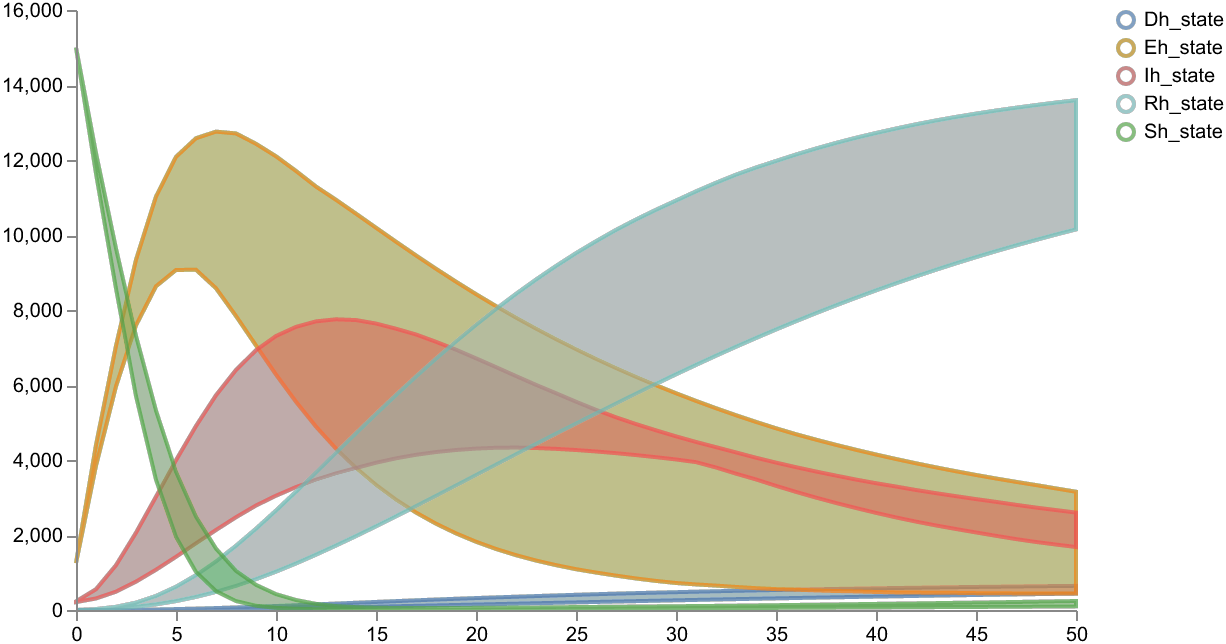

In [12]:
result = pyciemss.sample(model, end_time, logging_step_size, num_samples, start_time=start_time)
# display(result1['data'].head())

# Plot results for human states
schema = plots.trajectories(result["data"], keep=".*h_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

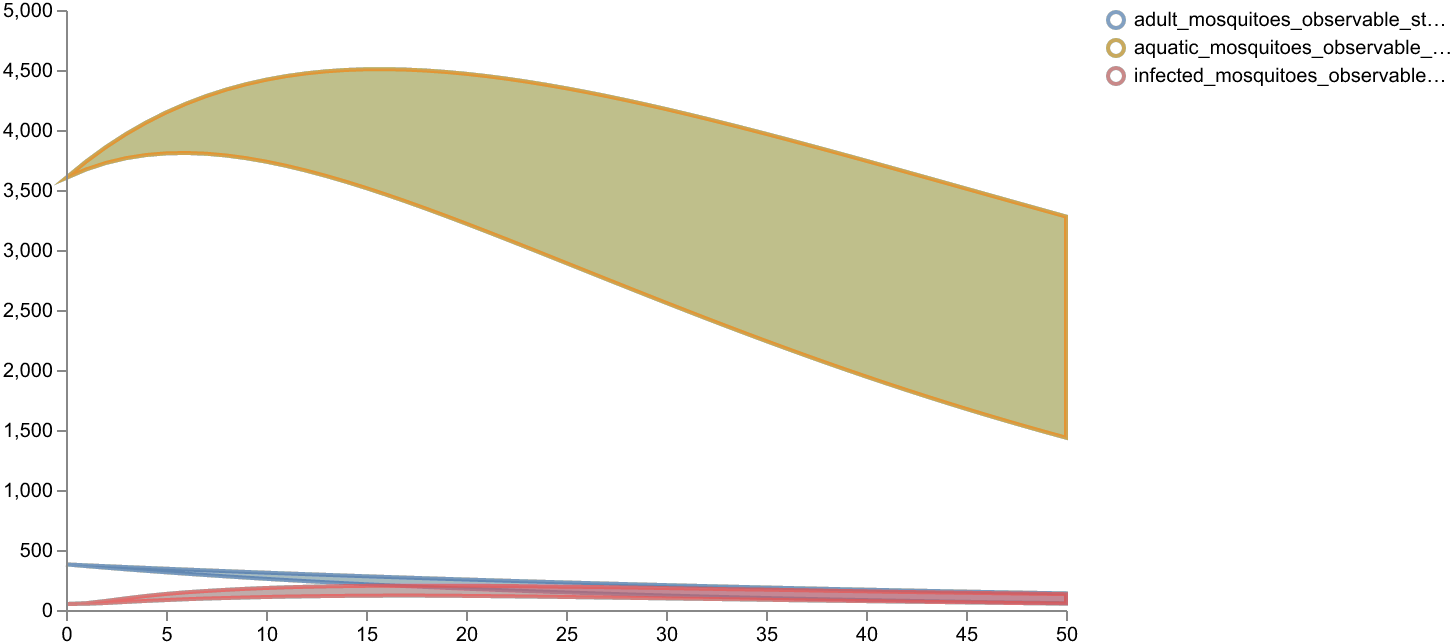

In [13]:
# Plot results for mosquito states
schema = plots.trajectories(result["data"], keep=".*mosquitoes_observable_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Create synthetic data

### Remove uncertainty in the transmission rate `beta` and the death rate `mu`

In [31]:
print(f"beta value: {malaria_model.parameters['beta'].value}")
malaria_model.parameters['beta'].distribution = None

print(f"mu value: {malaria_model.parameters['mu'].value}")
malaria_model.parameters['mu'].distribution = None

# Save as updated AMR
with open('malaria_model_const_beta_mu.json', 'w') as fh:
    json.dump(template_model_to_petrinet_json(malaria_model), fh, indent=1)

beta value: 0.0044
mu value: 0.0028


### Take a single sample of the updated model

In [21]:
model1 = 'malaria_model_const_beta_mu.json'
result1 = pyciemss.sample(model1, end_time, logging_step_size, 1, start_time=start_time)
display(result1['data'].head())

,timepoint_id,sample_id,timepoint_unknown,persistent_rho_param,persistent_phi_param,persistent_KG_param,persistent_KL_param,persistent_zeta_param,persistent_KP_param,persistent_kappai_param,...,Em_state,Sm_state,G_state,L_state,P_state,infected_humans_observable_state,deceased_humans_observable_state,infected_mosquitoes_observable_state,aquatic_mosquitoes_observable_state,adult_mosquitoes_observable_state
0,0,0,0.0,0.062621,0.004159,14963.839844,10139.355469,0.012,6785.64502,0.001019,...,30.000000,300.000000,2400.000000,800.000000,400.000000,214.457443,0.000000,50.000000,3600.000000,380.000000
1,1,0,1.0,0.062621,0.004159,14963.839844,10139.355469,0.012,6785.64502,0.001019,...,136.491470,182.075668,2546.471924,799.095398,386.463867,365.494537,0.772887,53.570019,3732.031250,372.137146
2,2,0,2.0,0.062621,0.004159,14963.839844,10139.355469,0.012,6785.64502,0.001019,...,251.362152,48.521160,2673.842285,801.868286,373.524109,662.349060,2.182138,64.543663,3849.234619,364.426971
3,3,0,3.0,0.062621,0.004159,14963.839844,10139.355469,0.012,6785.64502,0.001019,...,274.017914,3.314006,2784.058838,807.506470,361.167816,1072.090820,4.587470,79.535202,3952.733154,356.867096
4,4,0,4.0,0.062621,0.004159,14963.839844,10139.355469,0.012,6785.64502,0.001019,...,255.389465,0.145816,2878.875977,815.321472,349.382111,1562.317383,8.261207,93.920311,4043.579590,349.455597


### Add Gaussian and uniformly distributed noise to the simulated result

In [38]:
# Uniform noise: U(0.9 * value, 1.1 * value)
df_uniform = result1['data'].copy()
df_uniform['Ih_state'] = df_uniform['Ih_state'] * np.random.uniform(0.9, 1.1, df_uniform['Ih_state'].shape)
df_uniform['Dh_state'] = df_uniform['Dh_state'] * np.random.uniform(0.9, 1.1, df_uniform['Dh_state'].shape)

# Make sure all values are positive and round to nearest decimal
df_uniform['Ih_state'] = df_uniform['Ih_state'].abs().round(1)
df_uniform['Dh_state'] = df_uniform['Dh_state'].abs().round(1)

# Keep data to time 20
df_uniform = df_uniform.iloc[:21]

# Create the new dataframe for uniform noise
uniform_df = pd.DataFrame({
    'Timestamp': df_uniform['timepoint_unknown'],
    'Ih_data': df_uniform['Ih_state'],
    'Dh_data': df_uniform['Dh_state']
})

# Gaussian noise: N(mean = value, standard_deviation = 0.1 * value)
df_gaussian = result1['data'].copy()
df_gaussian['Ih_state'] = df_gaussian['Ih_state'] + np.random.normal(0, 0.1 * df_gaussian['Ih_state'], df_gaussian['Ih_state'].shape)
df_gaussian['Dh_state'] = df_gaussian['Dh_state'] + np.random.normal(0, 0.1 * df_gaussian['Dh_state'], df_gaussian['Dh_state'].shape)

# Make sure all values are positive and round to nearest decimal
df_gaussian['Ih_state'] = df_gaussian['Ih_state'].abs().round(1)
df_gaussian['Dh_state'] = df_gaussian['Dh_state'].abs().round(1)

# Keep data to time 20
df_gaussian = df_gaussian.iloc[:21]

# Create the new dataframe for Gaussian noise
gaussian_df = pd.DataFrame({
    'Timestamp': df_gaussian['timepoint_unknown'],
    'Ih_data': df_gaussian['Ih_state'],
    'Dh_data': df_gaussian['Dh_state']
})

# Save synthetic data
uniform_df.to_csv('synth_data_unif.csv', index=False)
gaussian_df.to_csv('synth_data_gaussian.csv', index=False)

## Calibrate the original model to the synthetically generated data

### Set up and perform calibration with normally distributed noisy data

In [39]:
dataset1 = 'synth_data_gaussian.csv'
data_mapping = {'Ih_data': 'Ih', 'Dh_data': 'Dh'}
num_iterations = 100

calibrated_result1 = pyciemss.calibrate(model, dataset1, data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates1 = calibrated_result1["inferred_parameters"]

display(parameter_estimates1())

calibrated_sample_result1 = pyciemss.sample(model, end_time, logging_step_size, num_samples, 
                                            start_time=start_time, inferred_parameters=parameter_estimates1)

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 20 rows of data. The first column, Timestamp, begins at 0.0 and ends at 20.0. The subsequent columns are named: Ih_data, Dh_data


{'persistent_beta': tensor(0.0046, grad_fn=<ExpandBackward0>),
 'persistent_rho': tensor(0.0651, grad_fn=<ExpandBackward0>),
 'persistent_mu': tensor(0.0028, grad_fn=<ExpandBackward0>),
 'persistent_phi': tensor(0.0053, grad_fn=<ExpandBackward0>),
 'persistent_KG': tensor(15236.9619, grad_fn=<ExpandBackward0>),
 'persistent_KL': tensor(9954.0830, grad_fn=<ExpandBackward0>),
 'persistent_zeta': tensor(0.0233, grad_fn=<ExpandBackward0>),
 'persistent_KP': tensor(6862.5166, grad_fn=<ExpandBackward0>),
 'persistent_kappai': tensor(0.0014, grad_fn=<ExpandBackward0>),
 'persistent_kappar': tensor(0.0203, grad_fn=<ExpandBackward0>),
 'persistent_chi': tensor(0.0524, grad_fn=<ExpandBackward0>),
 'persistent_I0': tensor(221.5072, grad_fn=<ExpandBackward0>)}

### Plot the result

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_param,persistent_rho_param,persistent_mu_param,persistent_phi_param,persistent_KG_param,persistent_KL_param,persistent_zeta_param,...,Em_state,Sm_state,G_state,L_state,P_state,infected_humans_observable_state,deceased_humans_observable_state,infected_mosquitoes_observable_state,aquatic_mosquitoes_observable_state,adult_mosquitoes_observable_state
0,0,0,0.0,0.004512,0.064612,0.002822,0.005241,15118.605469,10383.874023,0.017622,...,30.000000,300.000000,2400.000000,800.000000,400.000000,210.499603,0.000000,50.000000,3600.000000,380.000000
1,1,0,1.0,0.004512,0.064612,0.002822,0.005241,15118.605469,10383.874023,0.017622,...,156.010834,160.771133,2532.824219,794.757874,384.311249,368.986298,0.776295,53.268982,3711.893311,370.050964
2,2,0,2.0,0.004512,0.064612,0.002822,0.005241,15118.605469,10383.874023,0.017622,...,263.638824,33.412529,2645.458740,793.231262,369.375061,679.513245,2.224764,63.301094,3808.064941,360.352448
3,3,0,3.0,0.004512,0.064612,0.002822,0.005241,15118.605469,10383.874023,0.017622,...,273.347351,1.526628,2740.129639,794.566589,355.169739,1104.658447,4.719236,76.025421,3889.865967,350.899414
4,4,0,4.0,0.004512,0.064612,0.002822,0.005241,15118.605469,10383.874023,0.017622,...,253.742508,0.108127,2818.835449,798.044373,341.671173,1608.066284,8.533042,87.833977,3958.551025,341.684601


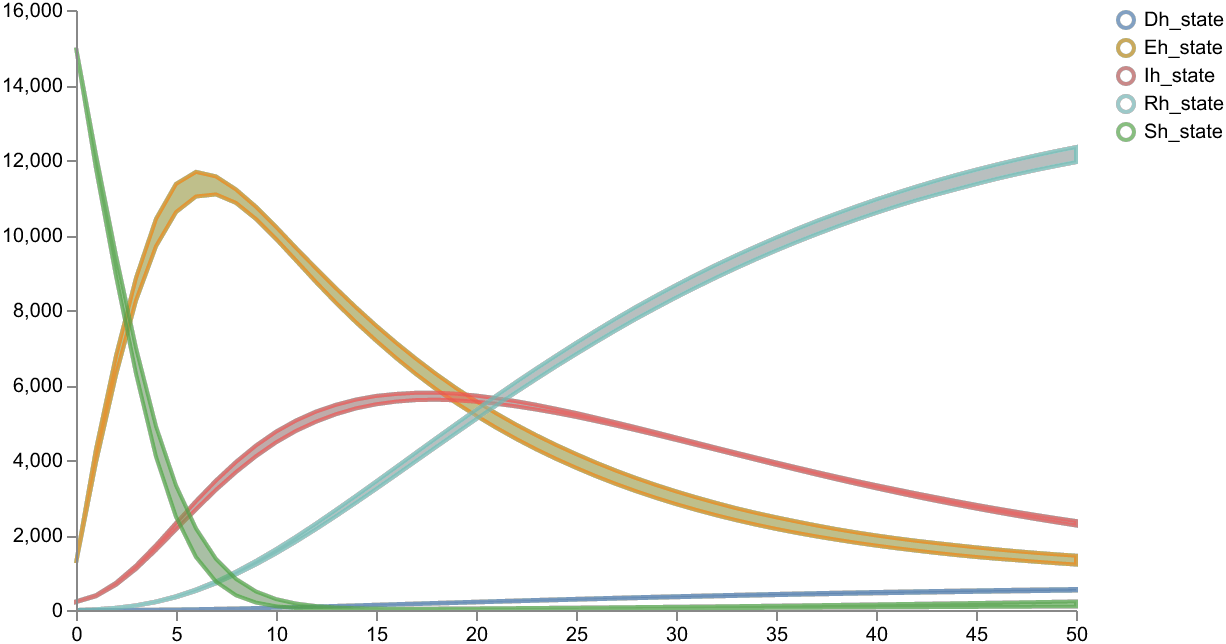

In [41]:
display(calibrated_sample_result1['data'].head())

# Plot results for human states
schema = plots.trajectories(calibrated_sample_result1["data"], keep=".*h_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Plot prior and calibrated `beta` distribution

/Users/altu809/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/altu809/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


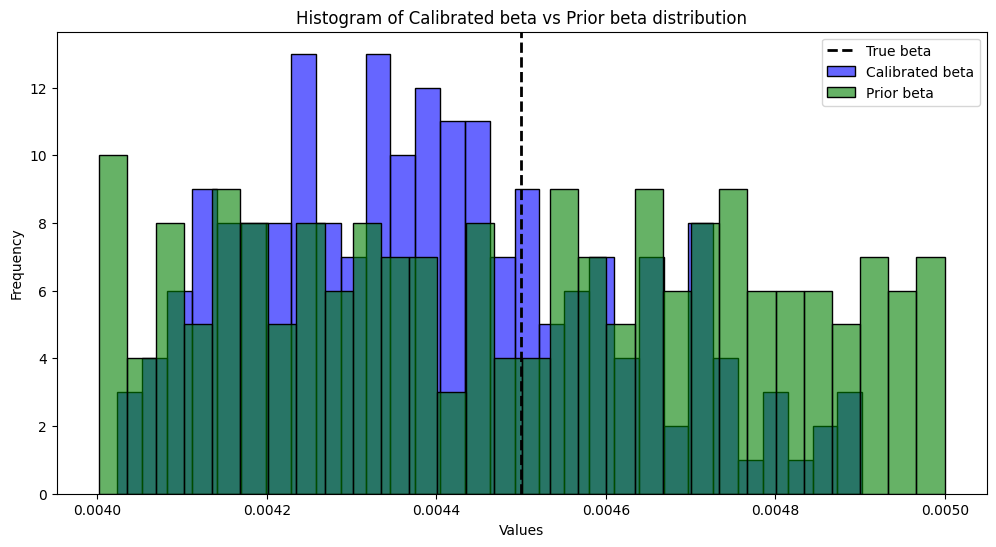

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract unique `persistent_beta_param` values
unique_beta_params = calibrated_sample_result1['data'][['sample_id', 'persistent_beta_param']].drop_duplicates()['persistent_beta_param']

# Generate uniform distribution data for comparison
uniform_data = np.random.uniform(0.004, 0.005, size=num_samples)

# Set up the plotting grid
plt.figure(figsize=(12, 6))

# Histogram of persistent_beta_param values
sns.histplot(unique_beta_params, kde=False, color='blue', bins=30, label='Calibrated beta', alpha=0.6)

# Histogram of uniform distribution
sns.histplot(uniform_data, kde=False, color='green', bins=30, label='Prior beta', alpha=0.6)

# Add vertical line at 0.0045
plt.axvline(x=0.0045, color='black', linestyle='--', linewidth=2, label='True beta')

# Add labels and legends
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Calibrated beta vs Prior beta distribution')
plt.legend()

# Show plot
plt.show()

### Plot prior and calibrated `mu` distribution

/Users/altu809/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


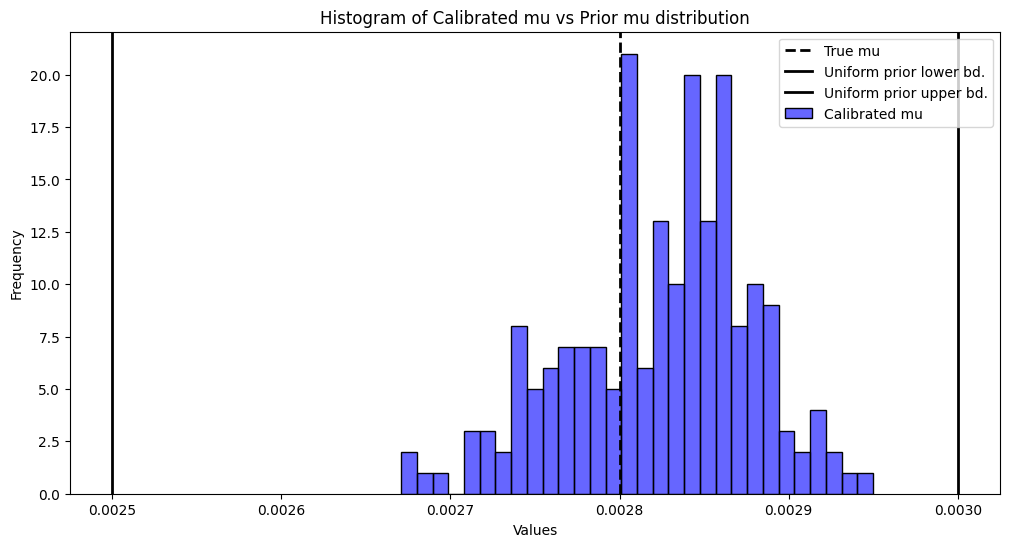

In [51]:
# Extract unique `persistent_mu_param` values
unique_mu_params = calibrated_sample_result1['data'][['sample_id', 'persistent_mu_param']].drop_duplicates()['persistent_mu_param']

# Generate uniform distribution data for comparison
uniform_data = np.random.uniform(0.0025, 0.003, size=num_samples)

# Set up the plotting grid
plt.figure(figsize=(12, 6))

# Histogram of persistent_beta_param values
sns.histplot(unique_mu_params, kde=False, color='blue', bins=30, label='Calibrated mu', alpha=0.6)

# Histogram of uniform distribution
# sns.histplot(uniform_data, kde=False, color='green', bins=30, label='Prior mu', alpha=0.6)

# Add vertical line at 0.0028
plt.axvline(x=0.0028, color='black', linestyle='--', linewidth=2, label='True mu')

plt.axvline(x=0.0025, color='black', linestyle='-', linewidth=2, label='Uniform prior lower bd.')
plt.axvline(x=0.003, color='black', linestyle='-', linewidth=2, label='Uniform prior upper bd.')

# Add labels and legends
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Calibrated mu vs Prior mu distribution')
plt.legend()

# Show plot
plt.show()

### Set up and perform calibration with normally distributed noisy data

In [47]:
dataset1 = 'synth_data_unif.csv'
data_mapping = {'Ih_data': 'Ih', 'Dh_data': 'Dh'}
num_iterations = 300

calibrated_result1 = pyciemss.calibrate(model, dataset1, data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates1 = calibrated_result1["inferred_parameters"]

display(parameter_estimates1())

calibrated_sample_result1 = pyciemss.sample(model, end_time, logging_step_size, num_samples, 
                                            start_time=start_time, inferred_parameters=parameter_estimates1)

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 20 rows of data. The first column, Timestamp, begins at 0.0 and ends at 20.0. The subsequent columns are named: Ih_data, Dh_data


{'persistent_beta': tensor(0.0047, grad_fn=<ExpandBackward0>),
 'persistent_rho': tensor(0.0605, grad_fn=<ExpandBackward0>),
 'persistent_mu': tensor(0.0029, grad_fn=<ExpandBackward0>),
 'persistent_phi': tensor(0.0051, grad_fn=<ExpandBackward0>),
 'persistent_KG': tensor(15355.5527, grad_fn=<ExpandBackward0>),
 'persistent_KL': tensor(9721.2832, grad_fn=<ExpandBackward0>),
 'persistent_zeta': tensor(0.0146, grad_fn=<ExpandBackward0>),
 'persistent_KP': tensor(7313.6182, grad_fn=<ExpandBackward0>),
 'persistent_kappai': tensor(0.0010, grad_fn=<ExpandBackward0>),
 'persistent_kappar': tensor(0.0189, grad_fn=<ExpandBackward0>),
 'persistent_chi': tensor(0.0637, grad_fn=<ExpandBackward0>),
 'persistent_I0': tensor(211.2089, grad_fn=<ExpandBackward0>)}

### Plot the result

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_param,persistent_rho_param,persistent_mu_param,persistent_phi_param,persistent_KG_param,persistent_KL_param,persistent_zeta_param,...,Em_state,Sm_state,G_state,L_state,P_state,infected_humans_observable_state,deceased_humans_observable_state,infected_mosquitoes_observable_state,aquatic_mosquitoes_observable_state,adult_mosquitoes_observable_state
0,0,0,0.0,0.004335,0.060229,0.002756,0.005208,15354.929688,10038.640625,0.011788,...,30.000000,300.000000,2400.000000,800.000000,400.000000,221.840515,0.000000,50.000000,3600.000000,380.000000
1,1,0,1.0,0.004335,0.060229,0.002756,0.005208,15354.929688,10038.640625,0.011788,...,143.704529,173.413971,2548.578613,799.238464,386.537720,365.502716,0.772306,55.097584,3734.354980,372.216064
2,2,0,2.0,0.004335,0.060229,0.002756,0.005208,15354.929688,10038.640625,0.011788,...,246.142365,49.688591,2678.010742,802.192017,373.665497,652.276489,2.145257,68.750526,3853.868164,364.581482
3,3,0,3.0,0.004335,0.060229,0.002756,0.005208,15354.929688,10038.640625,0.011788,...,265.869446,4.550547,2790.236328,808.046631,361.373108,1054.085327,4.473117,86.674057,3959.656006,357.094055
4,4,0,4.0,0.004335,0.060229,0.002756,0.005208,15354.929688,10038.640625,0.011788,...,245.766251,0.213121,2886.996338,816.106567,349.647156,1539.059204,8.031413,103.772247,4052.750244,349.751648


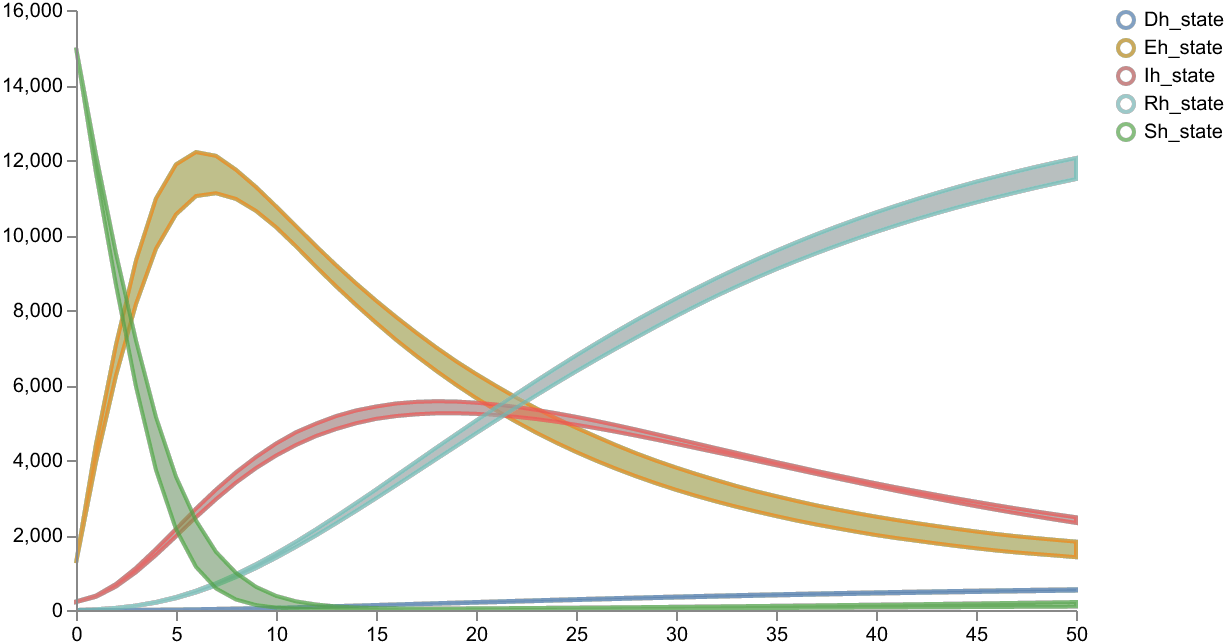

In [48]:
display(calibrated_sample_result1['data'].head())

# Plot results for human states
schema = plots.trajectories(calibrated_sample_result1["data"], keep=".*h_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Plot prior and calibrated `beta` distribution

/Users/altu809/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/altu809/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


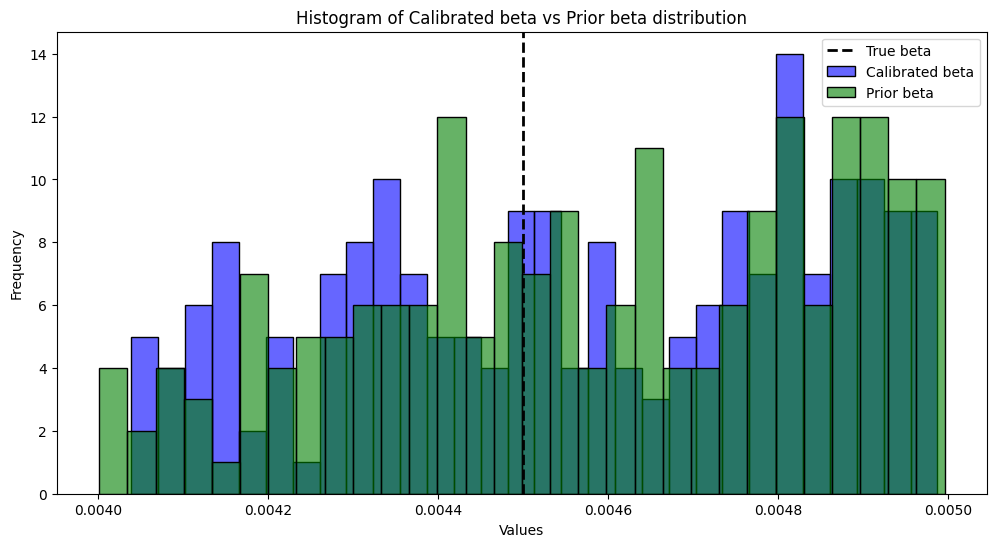

In [49]:
# Extract unique `persistent_beta_param` values
unique_beta_params = calibrated_sample_result1['data'][['sample_id', 'persistent_beta_param']].drop_duplicates()['persistent_beta_param']

# Generate uniform distribution data for comparison
uniform_data = np.random.uniform(0.004, 0.005, size=num_samples)

# Set up the plotting grid
plt.figure(figsize=(12, 6))

# Histogram of persistent_beta_param values
sns.histplot(unique_beta_params, kde=False, color='blue', bins=30, label='Calibrated beta', alpha=0.6)

# Histogram of uniform distribution
sns.histplot(uniform_data, kde=False, color='green', bins=30, label='Prior beta', alpha=0.6)

# Add vertical line at 0.0045
plt.axvline(x=0.0045, color='black', linestyle='--', linewidth=2, label='True beta')

# Add labels and legends
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Calibrated beta vs Prior beta distribution')
plt.legend()

# Show plot
plt.show()

### Plot prior and calibrated `mu` distribution

/Users/altu809/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/altu809/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


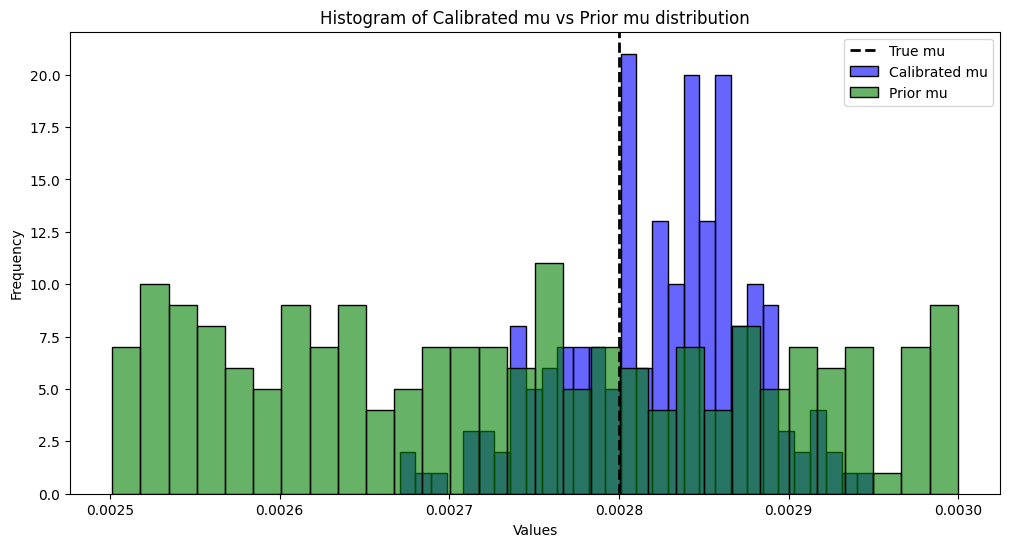

In [50]:
# Extract unique `persistent_mu_param` values
unique_mu_params = calibrated_sample_result1['data'][['sample_id', 'persistent_mu_param']].drop_duplicates()['persistent_mu_param']

# Generate uniform distribution data for comparison
uniform_data = np.random.uniform(0.0025, 0.003, size=num_samples)

# Set up the plotting grid
plt.figure(figsize=(12, 6))

# Histogram of persistent_beta_param values
sns.histplot(unique_mu_params, kde=False, color='blue', bins=30, label='Calibrated mu', alpha=0.6)

# Histogram of uniform distribution
sns.histplot(uniform_data, kde=False, color='green', bins=30, label='Prior mu', alpha=0.6)

# Add vertical line at 0.0028
plt.axvline(x=0.0028, color='black', linestyle='--', linewidth=2, label='True mu')

# Add labels and legends
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Calibrated mu vs Prior mu distribution')
plt.legend()

# Show plot
plt.show()